In [1]:
from utils import spark
from pyspark.sql import functions as F
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

23/06/06 19:18:05 WARN Utils: Your hostname, kayaba-kayaba resolves to a loopback address: 127.0.1.1; using 192.168.1.33 instead (on interface wlp3s0)
23/06/06 19:18:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/06 19:18:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [2]:
%%time
rating_df=spark.read.csv('data/ratings.csv',header=True)
tags_df=spark.read.csv("data/tags.csv",header=True)
title_df=spark.read.csv("data/movies.csv",header=True)

CPU times: user 40 ms, sys: 6.73 ms, total: 46.7 ms
Wall time: 57.1 s


In [3]:
%%time
print("jumlah User yang memberikan rating:",rating_df.select("userId").distinct().count())
print("Jumlah tidak ada Movies:",rating_df.select("movieId").distinct().count())
print("jumlah yang tidak ada tag ratings:",rating_df.select("rating").count())
print("Jumlah user yang tidak komentar:",tags_df.select("tag").distinct().count())
print("Jumlah film yang tidak komentar:",tags_df.select("movieId").distinct().count())
print("pesentasi pengguna yang berkomentar:",
      tags_df.select("tag").distinct().count()
      / rating_df.select("userId").distinct().count()*100)
print("persentasi film yang tidal berkomentar oleh user:",tags_df.select('movieId').distinct().count()
      / rating_df.select("movieId").distinct().count())

jumlah User yang memberikan rating: 162541


Jumlah tidak ada Movies: 59047


jumlah yang tidak ada tag ratings: 25000095


Jumlah user yang tidak komentar: 73051


Jumlah film yang tidak komentar: 45251


pesentasi pengguna yang berkomentar: 44.94312204305375


persentasi film yang tidal berkomentar oleh user: 0.7663556150185445
CPU times: user 279 ms, sys: 109 ms, total: 388 ms
Wall time: 8min 10s


In [4]:
rating_df=rating_df.drop('timestamp')
tags_df=tags_df.drop('timestamp')

In [5]:
title_df=title_df.withColumn("Year",F.regexp_extract("title",r'\((\d{4})\)',1))
title_df.show(n=3,truncate=False)

+-------+-----------------------+-------------------------------------------+----+
|movieId|title                  |genres                                     |Year|
+-------+-----------------------+-------------------------------------------+----+
|1      |Toy Story (1995)       |Adventure|Animation|Children|Comedy|Fantasy|1995|
|2      |Jumanji (1995)         |Adventure|Children|Fantasy                 |1995|
|3      |Grumpier Old Men (1995)|Comedy|Romance                             |1995|
+-------+-----------------------+-------------------------------------------+----+
only showing top 3 rows



In [6]:
# sss.show()

In [7]:
from pyspark.sql.functions import col, split, expr
# Separate genre into each column
split_cols = [split(col('genres'), '\|').getItem(i).alias(f'genre{i+1}') for i in range(10)]
split_cols.insert(0, col('movieId'))  # Add 'movieId' as the first column
sss = title_df.select(*split_cols, 'title', 'year')

# Count genres (non-zero values)
genre_columns = [col(f'genre{i+1}') for i in range(10)]
genre_count_expr = sum((col_name.isNotNull().cast(IntegerType())) for col_name in genre_columns)
title_df = sss.withColumn('genre_count', genre_count_expr)
title_df.show(3)


+-------+---------+---------+--------+------+-------+------+------+------+------+-------+--------------------+----+-----------+
|movieId|   genre1|   genre2|  genre3|genre4| genre5|genre6|genre7|genre8|genre9|genre10|               title|year|genre_count|
+-------+---------+---------+--------+------+-------+------+------+------+------+-------+--------------------+----+-----------+
|      1|Adventure|Animation|Children|Comedy|Fantasy|  null|  null|  null|  null|   null|    Toy Story (1995)|1995|          5|
|      2|Adventure| Children| Fantasy|  null|   null|  null|  null|  null|  null|   null|      Jumanji (1995)|1995|          3|
|      3|   Comedy|  Romance|    null|  null|   null|  null|  null|  null|  null|   null|Grumpier Old Men ...|1995|          2|
+-------+---------+---------+--------+------+-------+------+------+------+------+-------+--------------------+----+-----------+
only showing top 3 rows



In [8]:
rating_df.show(3)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    296|   5.0|
|     1|    306|   3.5|
|     1|    307|   5.0|
+------+-------+------+
only showing top 3 rows



In [9]:
from pyspark.sql.functions import avg, count

# Avg movie ratings by movieId and count
rating_avg = rating_df.groupBy('movieId').agg(avg('rating').alias('avg_rating'))
rating_count = rating_df.groupBy('movieId').agg(count('rating').alias('rating_count'))

# Avg user ratings by userId and count
user_rating = rating_df.groupBy('userId').agg(avg('rating').alias('avg_rating'))
user_count = rating_df.groupBy('userId').agg(count('rating').alias('rating_count'))

# Convert to PySpark DataFrames
rating_avg = rating_avg.withColumnRenamed('movieId', 'movieId')
rating_count = rating_count.withColumnRenamed('movieId', 'movieId').withColumnRenamed('rating_count', 'rating_count')
user_rating = user_rating.withColumnRenamed('userId', 'userId')
user_count = user_count.withColumnRenamed('userId', 'userId').withColumnRenamed('rating_count', 'rating_count')

# Merge DataFrames
df_movie = rating_avg.join(rating_count, 'movieId', 'inner')
df_movie = df_movie.orderBy('avg_rating', ascending=True)
df_user = user_rating.join(user_count, 'userId', 'inner')
df_user = df_user.orderBy('avg_rating', ascending=True)

In [10]:
df_user.show(4)

+------+----------+------------+
|userId|avg_rating|rating_count|
+------+----------+------------+
| 10364|       0.5|          20|
| 61102|       0.5|          20|
| 38998|       0.5|          20|
| 63044|       0.5|          20|
+------+----------+------------+
only showing top 4 rows



In [11]:
df_movie.show(4)

+-------+----------+------------+
|movieId|avg_rating|rating_count|
+-------+----------+------------+
| 203264|       0.5|           1|
| 197471|       0.5|           1|
| 207475|       0.5|           1|
| 179185|       0.5|           1|
+-------+----------+------------+
only showing top 4 rows



In [12]:
title_df.columns

['movieId',
 'genre1',
 'genre2',
 'genre3',
 'genre4',
 'genre5',
 'genre6',
 'genre7',
 'genre8',
 'genre9',
 'genre10',
 'title',
 'year',
 'genre_count']

In [13]:
cols = ['movieId','genre1']
dfk = title_df.select(*[col(c) for c in cols])
gabung_tag=tags_df.join(dfk,on="movieId",how='inner')
gabung_tag.show()

+-------+------+--------------------+---------+
|movieId|userId|                 tag|   genre1|
+-------+------+--------------------+---------+
|    260|     3|             classic|   Action|
|    260|     3|              sci-fi|   Action|
|   1732|     4|         dark comedy|   Comedy|
|   1732|     4|      great dialogue|   Comedy|
|   7569|     4|    so bad it's good|   Action|
|  44665|     4|unreliable narrators|    Crime|
| 115569|     4|               tense|    Crime|
| 115713|     4|artificial intell...|    Drama|
| 115713|     4|       philosophical|    Drama|
| 115713|     4|               tense|    Drama|
| 148426|     4|    so bad it's good|    Drama|
| 164909|     4|              cliche|   Comedy|
| 164909|     4|             musical|   Comedy|
| 168250|     4|              horror|   Horror|
| 168250|     4|       unpredictable|   Horror|
|   2160|    19|Oscar (Best Suppo...|    Drama|
|   7099|    19|           adventure|Adventure|
|   7099|    19|               anime|Adv

In [14]:
user_tags=tags_df.groupBy('userId', 'movieId').agg(F.count('tag').alias('tag_count'))
max_tag_count = user_tags.agg(F.max('tag_count')).first()[0]

# Filter the user_tags DataFrame to get rows with maximum tag count
user_tags_max = user_tags.filter(user_tags.tag_count == max_tag_count)

user_tags_max.show()

+------+-------+---------+
|userId|movieId|tag_count|
+------+-------+---------+
| 31047|    318|      337|
+------+-------+---------+



In [15]:
from pyspark.sql import functions as F

# Calculate tag count for each user
user_tagcount = tags_df.groupBy('userId').agg(F.count('tag').alias('tag_count'))

user_tagcount.show(3)


+------+---------+
|userId|tag_count|
+------+---------+
|  7273|       31|
| 11888|        3|
| 13282|        6|
+------+---------+
only showing top 3 rows



In [34]:
from pyspark.sql import functions as F

# Calculate tag count for each movie
movie_tagcount = tags_df.groupBy('movieId').agg(F.count('tag').alias('tag_count'))

# Join with movie data to get year and genres
movie_data = title_df.select('movieId', 'Year', 'genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10')
movie_tagcount = movie_tagcount.join(movie_data, 'movieId', 'left')

movie_tagcount.show(3)

+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+
|movieId|tag_count|Year|genre1|genre2|  genre3|  genre4|genre5|genre6|genre7|genre8|genre9|genre10|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+
| 115713|     2115|2015| Drama|Sci-Fi|Thriller|    null|  null|  null|  null|  null|  null|   null|
|    296|     4767|1994|Comedy| Crime|   Drama|Thriller|  null|  null|  null|  null|  null|   null|
| 177595|       14|1958|Horror|Sci-Fi|    null|    null|  null|  null|  null|  null|  null|   null|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+
only showing top 3 rows



In [35]:
from pyspark.sql.functions import col

# Select columns from df3
df3_cols = ['movieId', 'genre_count', 'genre1']
dfs = title_df.select(*df3_cols)

# Join movie_tagcount with dfs
movie_tagcount = movie_tagcount.join(dfs, on='movieId', how='inner')

movie_tagcount.show(3)


+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+-----------+------+
|movieId|tag_count|Year|genre1|genre2|  genre3|  genre4|genre5|genre6|genre7|genre8|genre9|genre10|genre_count|genre1|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+-----------+------+
| 115713|     2115|2015| Drama|Sci-Fi|Thriller|    null|  null|  null|  null|  null|  null|   null|          3| Drama|
|    296|     4767|1994|Comedy| Crime|   Drama|Thriller|  null|  null|  null|  null|  null|   null|          4|Comedy|
| 177595|       14|1958|Horror|Sci-Fi|    null|    null|  null|  null|  null|  null|  null|   null|          2|Horror|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+-----------+------+
only showing top 3 rows



In [36]:
from pyspark.sql.functions import col

# Join df3 with df_movie
df3 = title_df.join(df_movie, on='movieId', how='inner')

# Rename column
df3 = df3.withColumnRenamed('rating', 'avg_rating')

df3.show(3)


+-------+-----------+------+--------+------+------+------+------+------+------+-------+-------------------+----+-----------+------------------+------------+
|movieId|     genre1|genre2|  genre3|genre4|genre5|genre6|genre7|genre8|genre9|genre10|              title|year|genre_count|        avg_rating|rating_count|
+-------+-----------+------+--------+------+------+------+------+------+------+-------+-------------------+----+-----------+------------------+------------+
| 100008|Documentary|  null|    null|  null|  null|  null|  null|  null|  null|   null|   Flaw, The (2011)|2011|          1|3.5714285714285716|          14|
| 100040|      Crime| Drama|Thriller|  null|  null|  null|  null|  null|  null|   null|  True Blue (2001) |2001|          3|2.6666666666666665|           3|
| 100054|      Drama|  null|    null|  null|  null|  null|  null|  null|  null|   null|Stella Maris (1918)|1918|          1|               3.3|           5|
+-------+-----------+------+--------+------+------+------+

# Data Visual

In [19]:
from pyspark.sql.functions import col
genre_count = df3.groupBy("genre1").count().alias("Count")
genre_count = genre_count.select(col('genre1').alias('genre'),col('Count'))
genre_count.show(3)

+--------+-----+
|   genre|Count|
+--------+-----+
|   Crime| 2845|
| Romance|  376|
|Thriller|  884|
+--------+-----+
only showing top 3 rows



In [20]:
genre_count_df=genre_count.toPandas()
genre_count_df.sort_values(by='Count',ascending=False,inplace=True)

In [21]:
genre_count_df

,genre,Count
4,Drama,14624
15,Comedy,12936
17,Action,6913
6,Documentary,5068
12,(no genres listed),4568
13,Horror,3300
0,Crime,2845
3,Adventure,2319
10,Animation,2074
16,Children,1323


<Axes: xlabel='Count', ylabel='genre'>

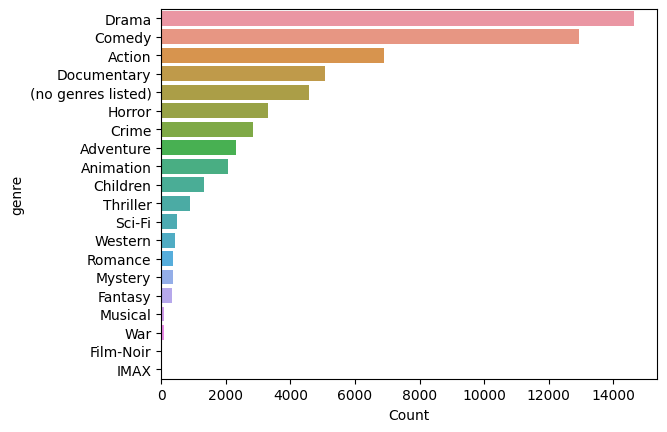

In [22]:
sns.barplot(y=genre_count_df['genre'],x=genre_count_df['Count'])

In [23]:
gabung_tag.show(3)

+-------+------+-----------+------+
|movieId|userId|        tag|genre1|
+-------+------+-----------+------+
|    260|     3|    classic|Action|
|    260|     3|     sci-fi|Action|
|   1732|     4|dark comedy|Comedy|
+-------+------+-----------+------+
only showing top 3 rows



In [24]:
comedy = gabung_tag.filter(F.col('genre1') == "Comedy")
tagdf=comedy.toPandas()
tagdf.head(3)

,movieId,userId,tag,genre1
0,1732,4,dark comedy,Comedy
1,1732,4,great dialogue,Comedy
2,164909,4,cliche,Comedy


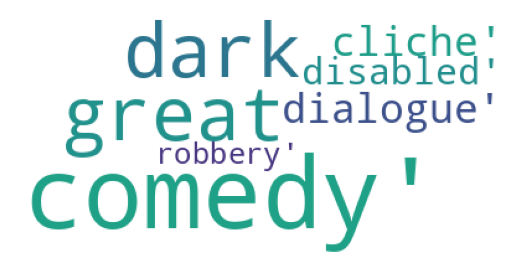

In [25]:
from wordcloud import WordCloud
text=tagdf['tag'].values
wordcloud = WordCloud(background_color ='white', relative_scaling=0.5).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

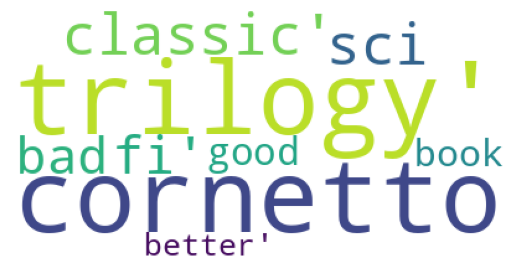

In [26]:
action = gabung_tag.filter(F.col('genre1') == "Action")
action_df=action.toPandas()
text = action_df['tag'].values 

wordcloud = WordCloud(background_color ='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [27]:
from pyspark.sql import functions as F

# Group by 'Year' and 'genre1', and count the number of movies
genre_by_year = df3.groupby('Year', 'genre1').agg(F.count('title').alias('count'))

# Pivot the DataFrame to convert 'genre1' values into columns
# genre_by_year = genre_by_year.groupBy('Year').pivot('genre1').agg(F.first('count'))

# Display the resulting DataFrame
genre_by_year.show()


+----+------------------+-----+
|Year|            genre1|count|
+----+------------------+-----+
|1967|             Drama|   79|
|2006|         Adventure|   64|
|1997|          Children|   33|
|1978|         Adventure|   12|
|1984|            Comedy|  101|
|1958|             Drama|   70|
|1950|(no genres listed)|   15|
|1994|             Crime|   24|
|2008|           Fantasy|   11|
|1966|            Horror|   25|
|1941|           Mystery|    2|
|1925|             Crime|    2|
|1928|(no genres listed)|    4|
|1923|(no genres listed)|    2|
|1912|            Comedy|    1|
|1895|       Documentary|    8|
|1931|            Horror|    2|
|1933|             Drama|   47|
|1992|         Adventure|   24|
|1961|             Crime|   15|
+----+------------------+-----+
only showing top 20 rows



In [28]:
genre_by_year_pd=genre_by_year.toPandas()
genre_by_year_pd

,Year,genre1,count
0,1967,Drama,79
1,2006,Adventure,64
2,1997,Children,33
3,1978,Adventure,12
4,1984,Comedy,101
...,...,...,...
1753,1988,Romance,2
1754,1988,Film-Noir,1
1755,1912,Romance,1
1756,2015,Western,1


In [29]:
genre_by_year1 = genre_by_year.filter(F.col('Year') >= "1945")
genre_by_year1.show(3)

+----+---------+-----+
|Year|   genre1|count|
+----+---------+-----+
|1967|    Drama|   79|
|2006|Adventure|   64|
|1997| Children|   33|
+----+---------+-----+
only showing top 3 rows



In [30]:
genre_by_year1_pd=genre_by_year1.toPandas()
genre_by_year1_pd.head(2)

,Year,genre1,count
0,1967,Drama,79
1,2006,Adventure,64


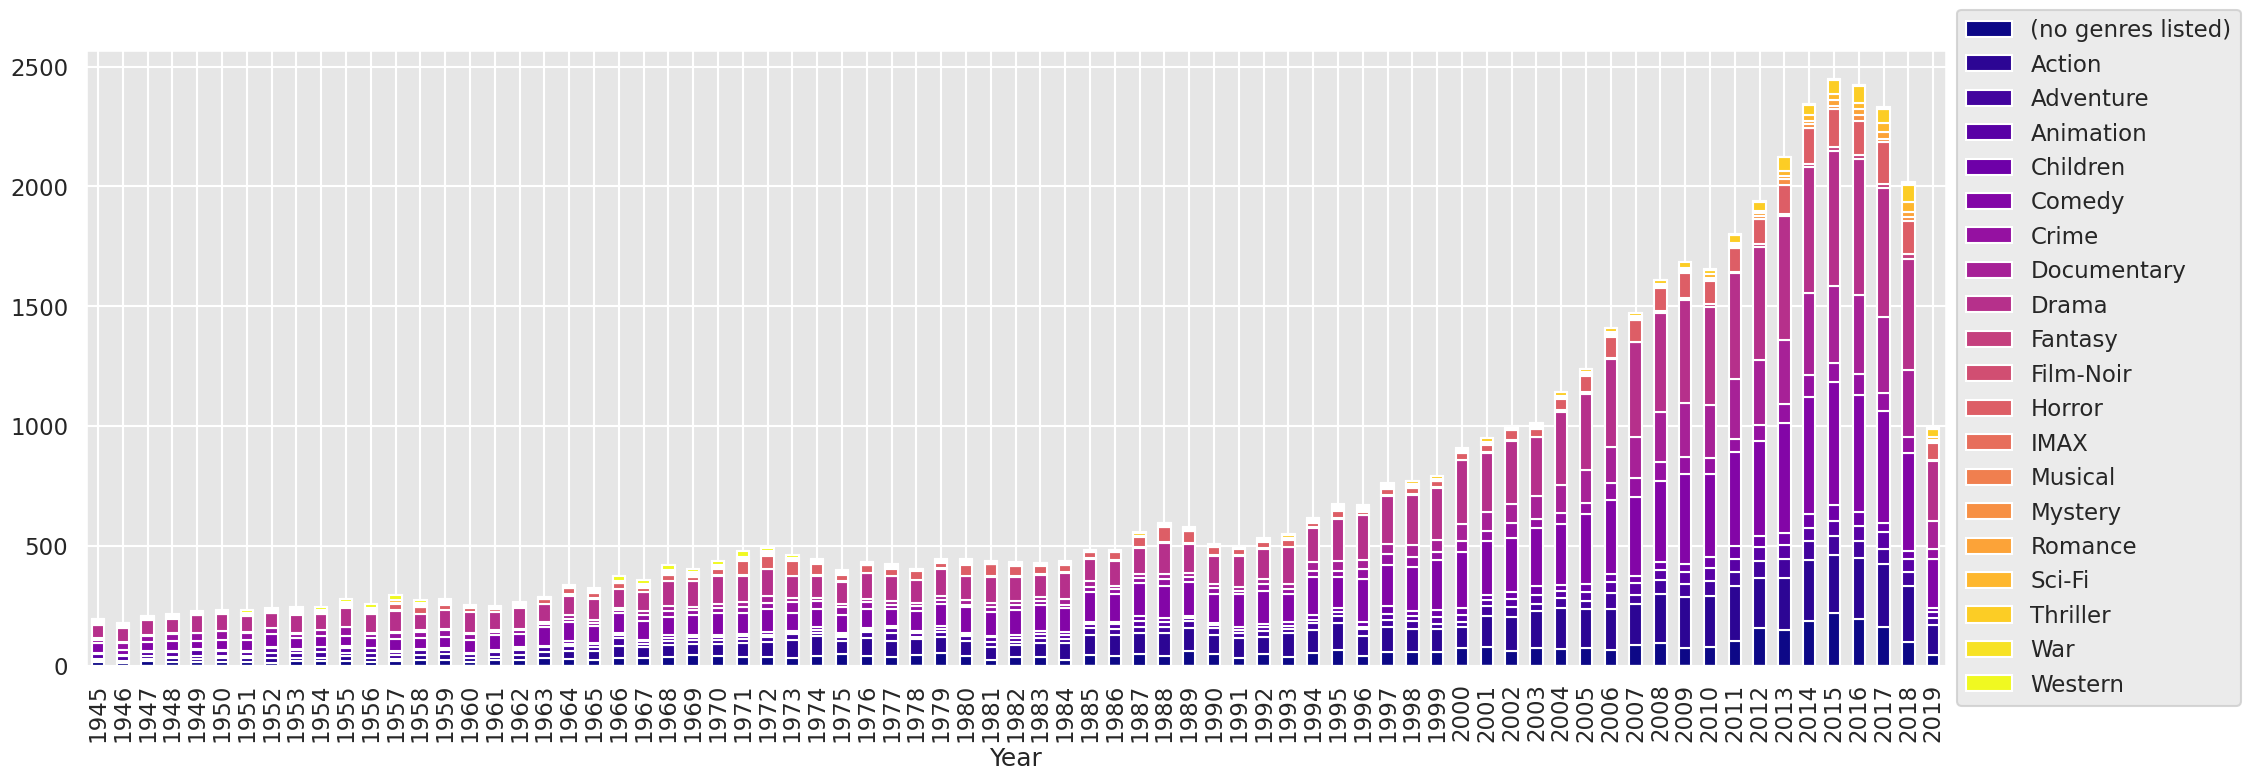

In [31]:
import pandas as pd
sns.set(rc={'figure.figsize':(24, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_pivot = pd.pivot_table(genre_by_year1_pd, index='Year', columns='genre1', values='count')
df_pivot.plot.bar(stacked=True, colormap='plasma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [39]:
from pyspark.sql import functions as F

# Group by 'genre1' and 'Year', and calculate the mean of 'avg_rating'
genre_pop = df3.groupby('genre1', 'Year').agg(F.mean(df3['avg_rating']).alias('rata_rata'))

# Show the resulting DataFrame
genre_pop.show()

+-----------+----+------------------+
|     genre1|Year|         rata_rata|
+-----------+----+------------------+
|     Sci-Fi|2010|2.5701266032728887|
|     Sci-Fi|1976| 2.870879120879121|
|     Action|1974|2.8522794485708127|
|     Comedy|1915| 2.567760942760943|
|  Animation|1944|3.0855357142857143|
|   Children|1985| 3.136220243833026|
|    Mystery|1934|           2.09375|
|  Adventure|1936|2.9496883781423255|
|      Crime|1970|2.9872202787833815|
|      Crime|1940|2.9496975806451613|
|      Crime|1927|3.4300653594771244|
|        War|1988| 2.909090909090909|
|     Sci-Fi|1973|2.5166666666666666|
|   Children|1974|3.0565047490605375|
|   Thriller|2019|1.9814135564135564|
|     Comedy|1955| 3.212393004293333|
|      Crime|1935|3.0612228607918266|
|    Western|1975|2.7208724365658674|
|Documentary|1975| 3.434138191724923|
|     Comedy|1926| 3.200153219827241|
+-----------+----+------------------+
only showing top 20 rows



In [41]:
rata2_comedy=genre_pop.filter(F.col('genre1') == "Comedy")
rata2_action=genre_pop.filter(F.col('genre1') == "Action")
rata2_horror=genre_pop.filter(F.col('genre1')=='Horror')
rata2_drama=genre_pop.filter(F.col('genre1')=='Drama')

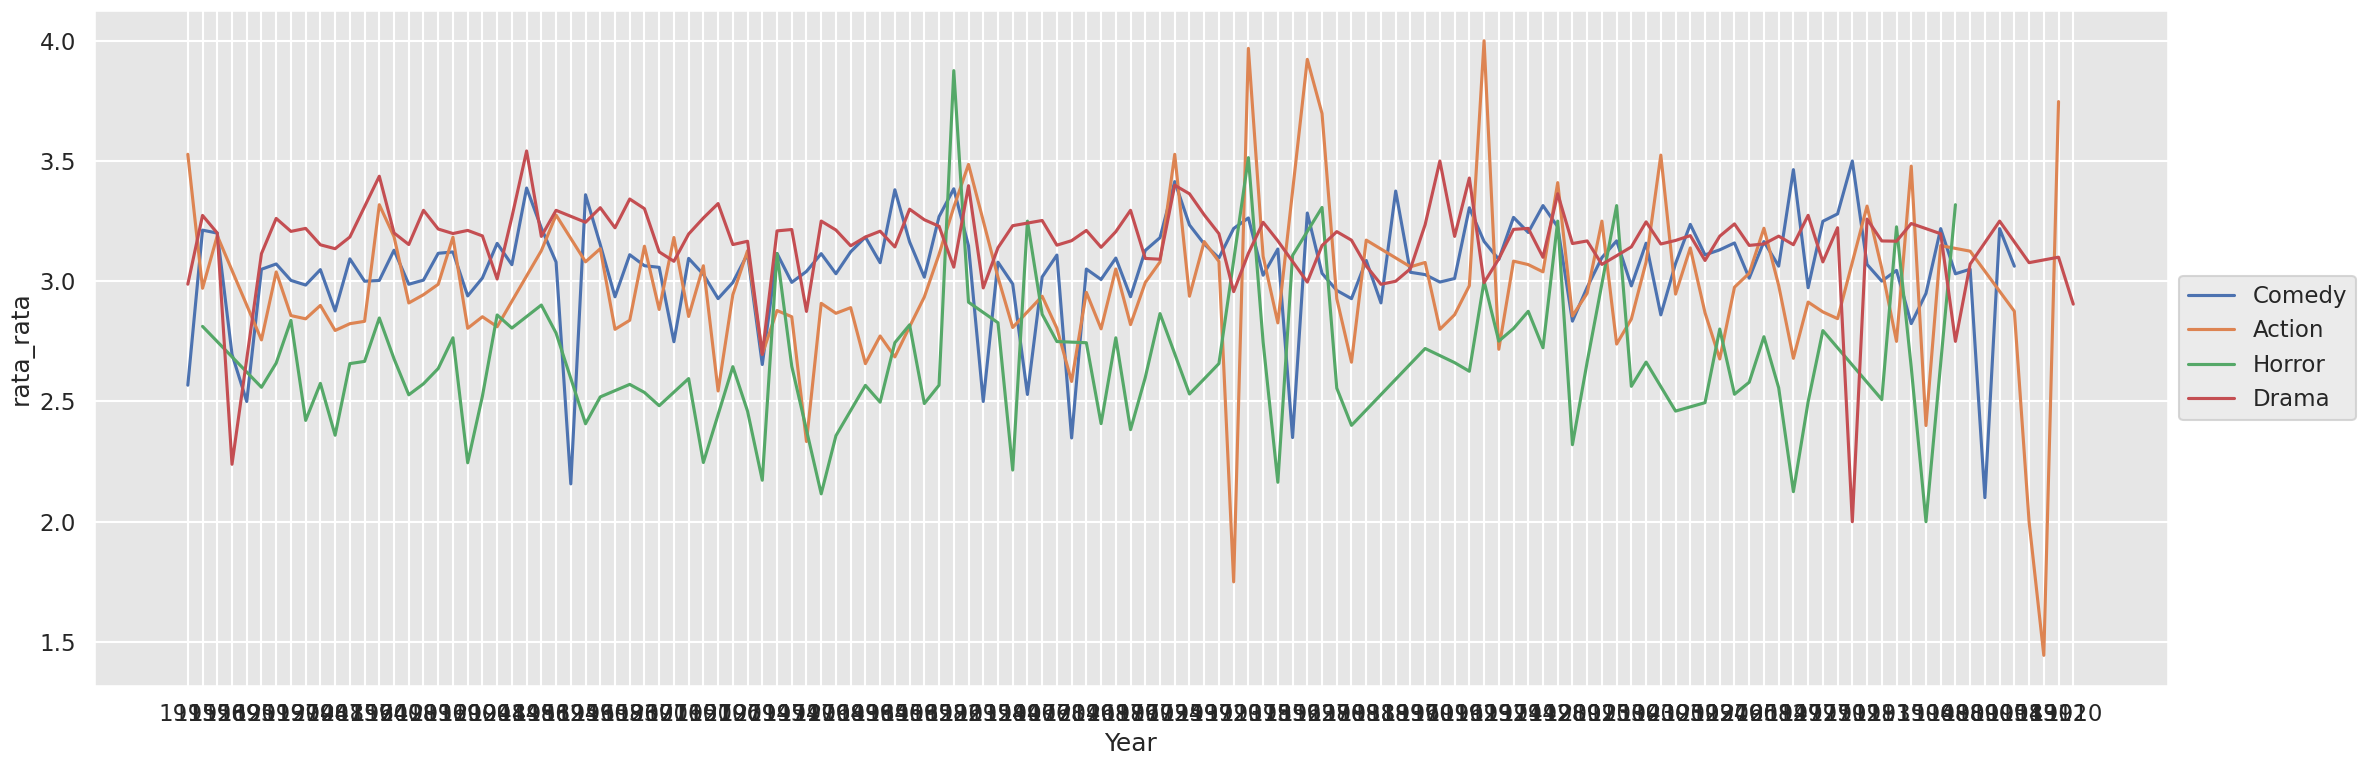

In [43]:
comedy_pd = rata2_comedy.toPandas()
action_pd = rata2_action.toPandas()
horror_pd = rata2_horror.toPandas()
drama_pd = rata2_drama.toPandas()
# Plot the average ratings for each genre over the years
sns.lineplot(x="Year", y="rata_rata", data=comedy_pd, label="Comedy")
sns.lineplot(x="Year", y="rata_rata", data=action_pd, label="Action")
sns.lineplot(x="Year", y="rata_rata", data=horror_pd, label="Horror")
sns.lineplot(x="Year", y="rata_rata", data=drama_pd, label="Drama")
# Adjust legend position
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
from pyspark.sql import functions as F

# Sort the DataFrame by rating_count in descending order
top10_mov = df3.orderBy(F.desc('rating_count'))

# Select the top 10 movies
top10_mov = top10_mov.limit(10)

# Select the necessary columns
top10mov = top10_mov.select('movieId', 'title')

# Show the top 10 movies
top10mov.show()


+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|    356| Forrest Gump (1994)|
|    318|Shawshank Redempt...|
|    296| Pulp Fiction (1994)|
|    593|Silence of the La...|
|   2571|  Matrix, The (1999)|
|    260|Star Wars: Episod...|
|    480|Jurassic Park (1993)|
|    527|Schindler's List ...|
|    110|   Braveheart (1995)|
|   2959|   Fight Club (1999)|
+-------+--------------------+



In [48]:
# Perform inner join on 'movieId'
top10mov = top10mov.join(rating_df, on='movieId', how='inner')

# Count the number of rows and columns in the resulting DataFrame
num_rows = top10mov.count()
num_cols = len(top10mov.columns)

# Print the shape of the DataFrame
print("Shape: ({}, {})".format(num_rows, num_cols))


Shape: (700675, 4)


In [49]:
top10mov.show(10,truncate=True)

+-------+--------------------+------+------+
|movieId|               title|userId|rating|
+-------+--------------------+------+------+
|    296| Pulp Fiction (1994)|     1|   5.0|
|    110|   Braveheart (1995)|     2|   5.0|
|    260|Star Wars: Episod...|     2|   5.0|
|    318|Shawshank Redempt...|     2|   5.0|
|    356| Forrest Gump (1994)|     2|   4.5|
|    480|Jurassic Park (1993)|     2|   2.0|
|    527|Schindler's List ...|     2|   5.0|
|   2571|  Matrix, The (1999)|     2|   5.0|
|    260|Star Wars: Episod...|     3|   4.0|
|    296| Pulp Fiction (1994)|     3|   5.0|
+-------+--------------------+------+------+
only showing top 10 rows



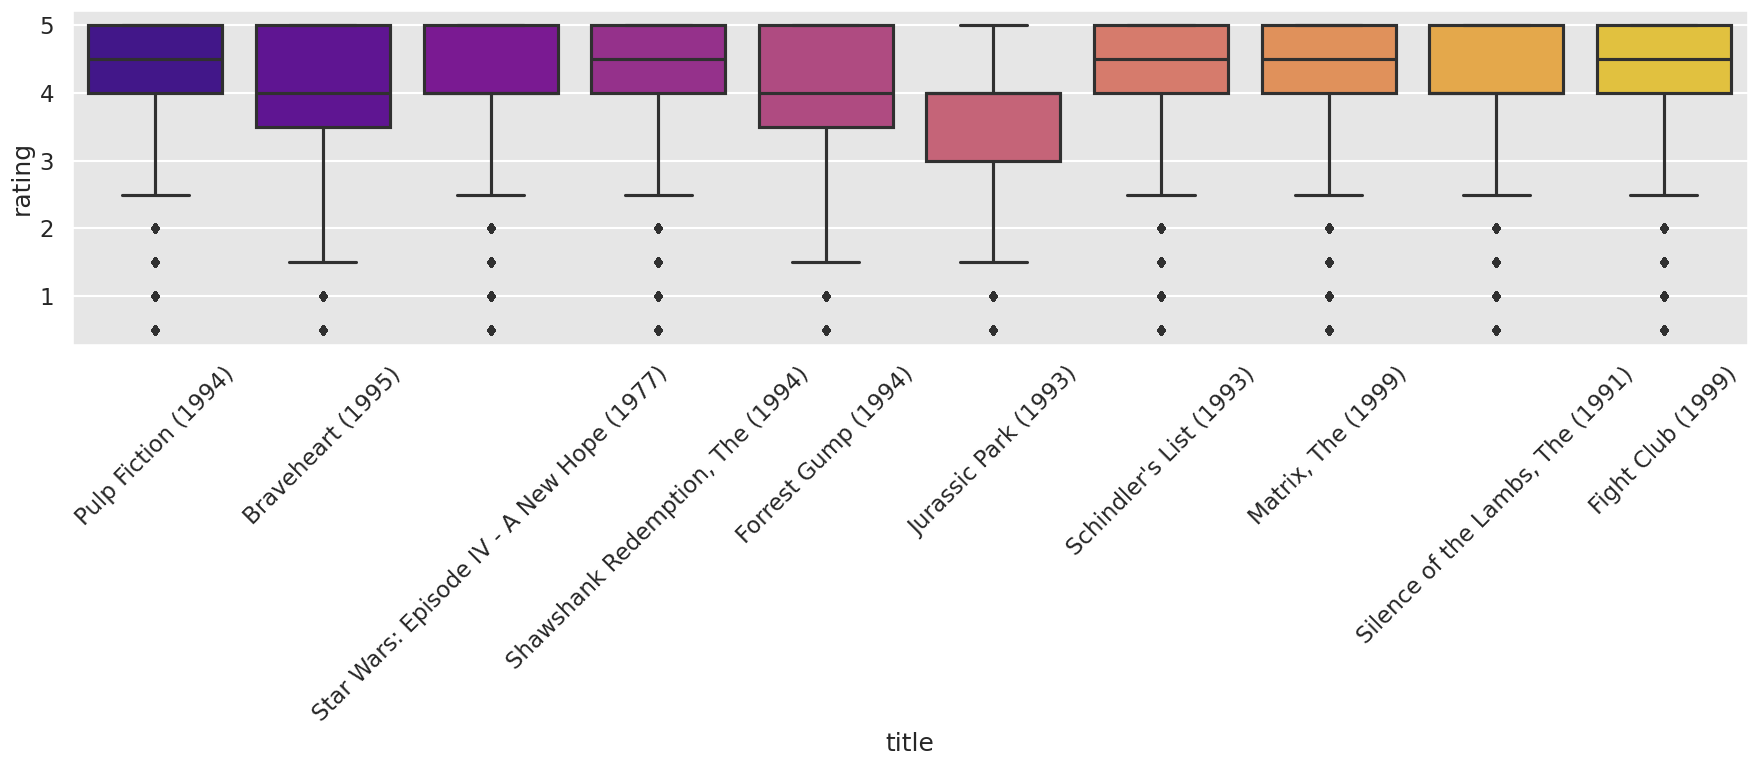

In [51]:
top10mov_pd = top10mov.toPandas()
top10mov_pd['rating'] = pd.to_numeric(top10mov_pd['rating'])
# Set the figure size
plt.figure(figsize=(18, 8))

# Create the box plot
sns.boxplot(x='title', y='rating', data=top10mov_pd, palette='plasma')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

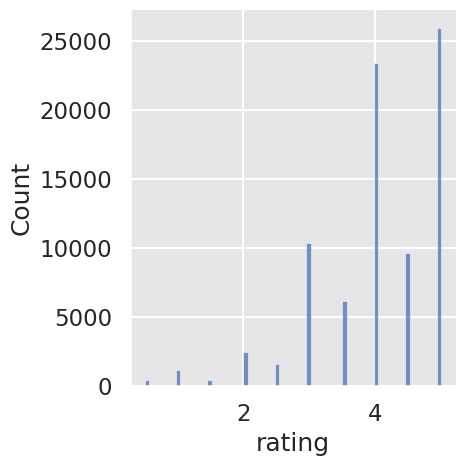

In [55]:
kkk = top10mov_pd[top10mov_pd['movieId']=='356']
sns.displot(kkk.rating)